<a href="https://colab.research.google.com/github/Richardhzj/ML/blob/main/GCN/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 14.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=db11212b25a9dbf59fd9f83fa5e6ce33739d2339231bc845752270ada8750efa
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [ ]:
pip install networks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for networks: filename=networks-0.3.7-py3-none-any.whl size=11635 sha256=fc885fab0cb4eb66112c04487cbdf2bf250e413822bab81ba874498b15344676
  Stored in directory: /root/.cache/pip/wheels/ff/67/17/406c586d04b0cb8e190903c362efbbf442987a74d5df2a78e4
Successfully built networks


In [ ]:
%matplotlib inline
import torch
import networkx as nx # draw graph
import matplotlib.pyplot as plt

In [ ]:
def visualize_graph(G, color):
  plt.figure(figsize=(7,7))
  plt.xticks([])
  plt.yticks([])
  nx.draw_networkx(G,pos=nx.spring_layout(G,seed=42), with_labels=False,
                   node_color=color,cmap="Set2")
  plt.show()

def visualize_embedding(h,color, epoch=None, loss=None):
  plt.figure(figsize=(7,7))
  plt.xticks([])
  plt.yticks([])
  h = h.detach().cpu().numpy()
  plt.scatter(h[:,0],h[:,1],s=140,c=color,cmap="Set2")
  if epoch is not None and loss is not None:
    plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}',fontsize=16)
  plt.show()

# dataset: Zachary's karate club network.
## A club which has 34 members
## if members have relationships after club, then add one edge.
## each node has a 34-dimension feature vector. There are 78 edges in total.

## Task: Two coaches have conflict. Now we need to predict for each member whether they go with coach A build a new club, or find a new coach or quit the club.

In [ ]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print("dataset", dataset)
print("number of graphs: ",len(dataset))
print("number of features",dataset.num_features)
print("number of classes",dataset.num_classes)

dataset KarateClub()
number of graphs:  1
number of features 34
number of classes 4


# the task is do classification for vertices in one graph.

# train_mask 
for example,label is:
\begin{matrix}
 2 \\
 x \\
 x \\
 x \\
 1 \\
\end{matrix}
Then train_mask is 
\begin{matrix}
 true \\
 false \\
 false \\
 false \\
 true \\
\end{matrix}
use to choose during training, which vertices we need to use to compute loss.
Only use vertices with labels


In [ ]:
# for other task, we may have multiple graphs. but now we only have one graph.
data = dataset[0] # get the first graph object
print(data)
# x = [M, F], M: # of samples, F: # of features, y is # of label. 


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


# edge_index
## edge_index = [2,n], 2 is [source,target],
## node feature: features for each node
## node labels
# train_mask: some nodes also may have no label

In [ ]:
# sparse representation
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

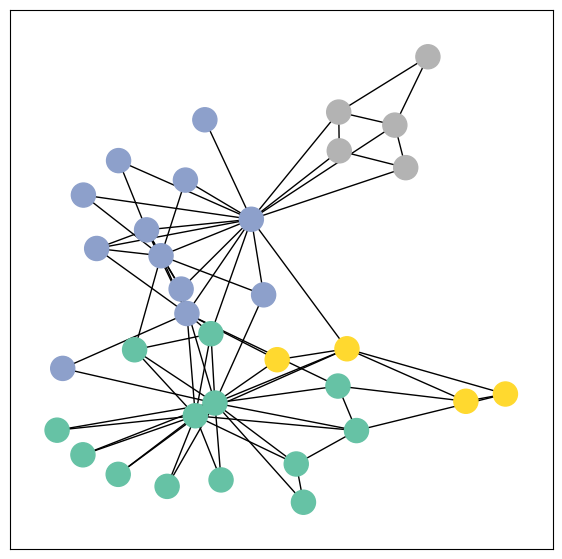

In [ ]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
visualize_graph(G,color=data.y)
# 4 classes

# GCN networks

In [ ]:
from torch_geometric.nn.conv.gcn_conv import GCNConv
from torch.nn import Linear
from torch_geometric.nn import GENConv
class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(1234)
    self.conv1 = GCNConv(dataset.num_features,4)
    self.conv2 = GCNConv(4,4)
    self.conv3 = GCNConv(4,2)
    self.classifier = Linear(2, dataset.num_classes)
  def forward(self, x, edge_index):
    # print("initial", x.shape)
    h = self.conv1(x, edge_index)
    # print(type(h))
    # print("second",h.shape)
    h = h.tanh()
    h = self.conv2(h, edge_index)
    # print("third",h.shape)
    h = h.tanh()
    h=self.conv3(h, edge_index)
    # print("forth",h.shape)
    h = h.tanh()

    out = self.classifier(h)
    # print(out.shape)
    return out, h
model =GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


index shape  torch.Size([2, 156])
Embedding shape: [34, 2]


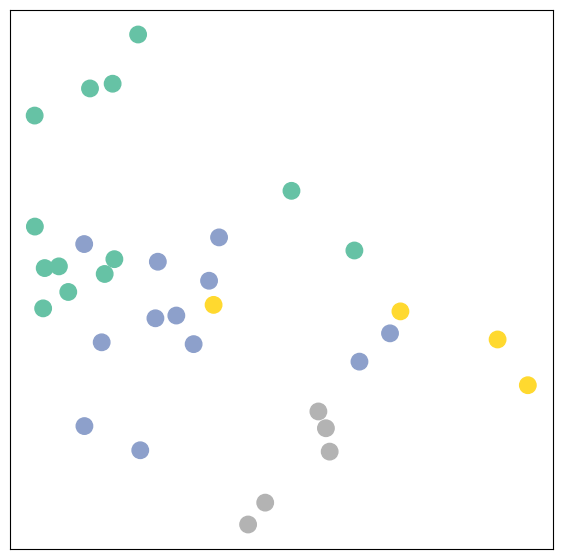

In [ ]:
model=GCN()
print("index shape ",data.edge_index.shape)
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)


# Semi-supervised

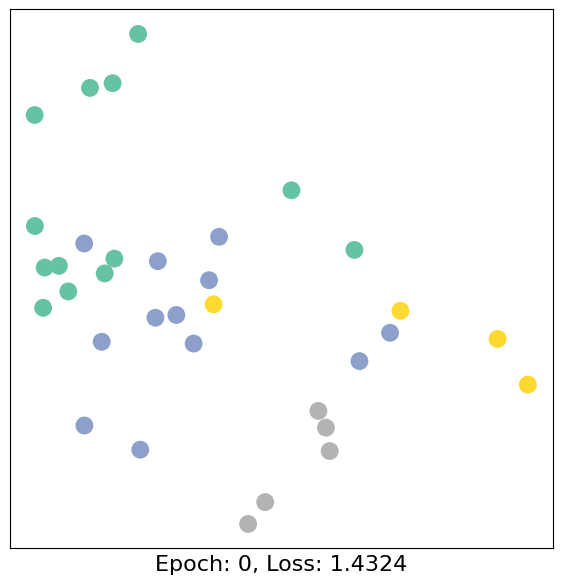

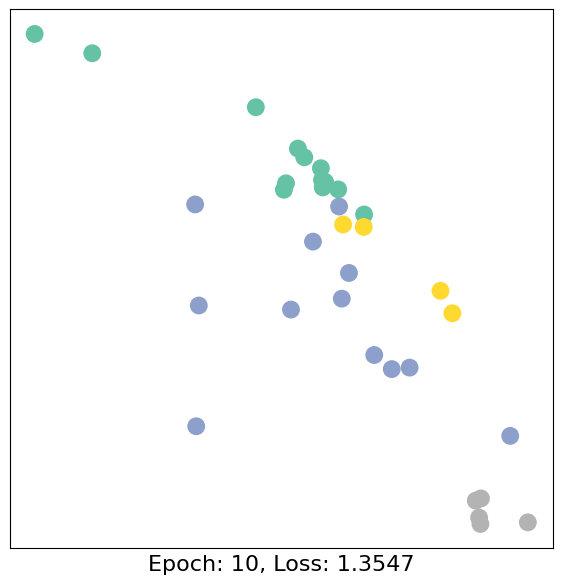

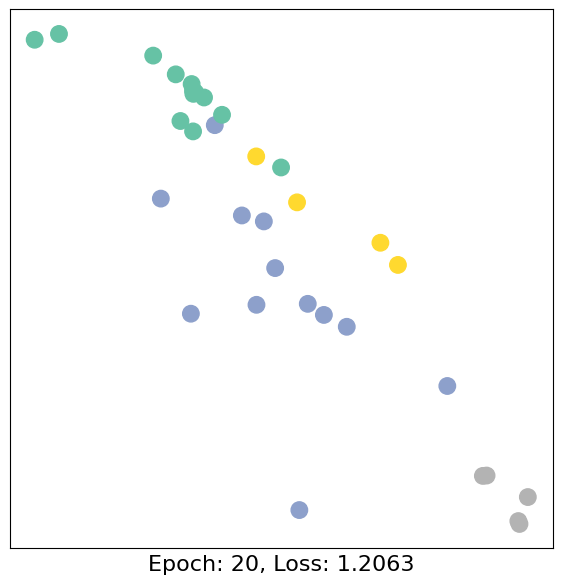

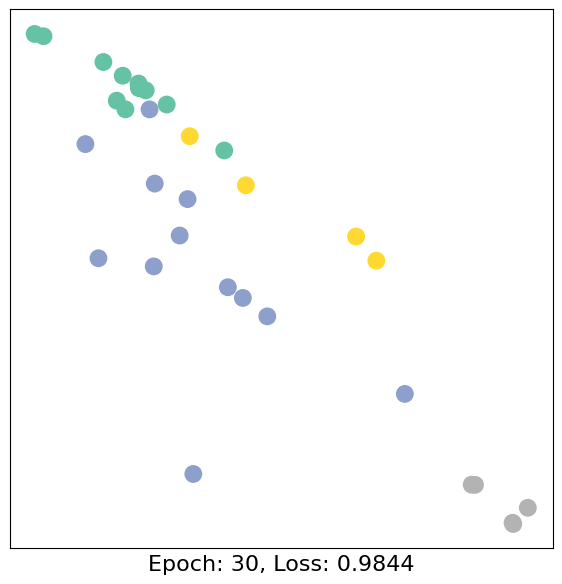

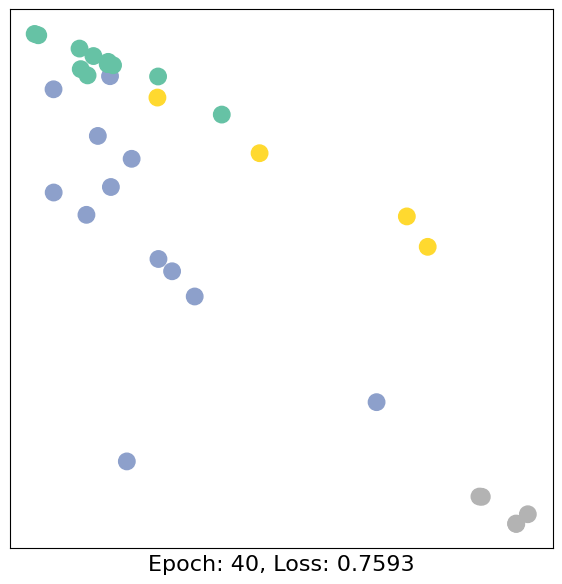

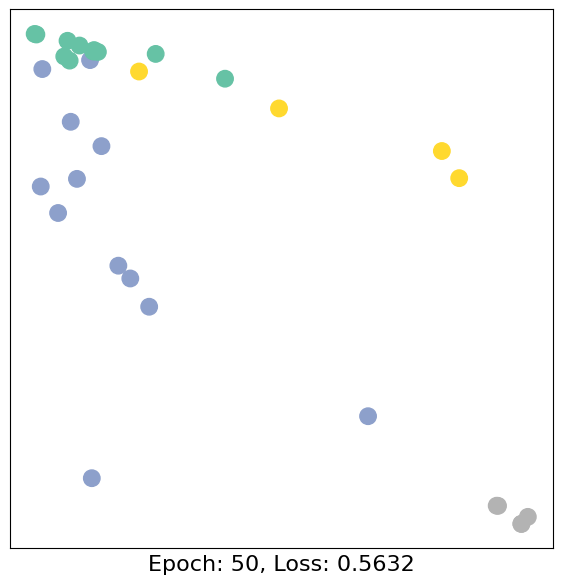

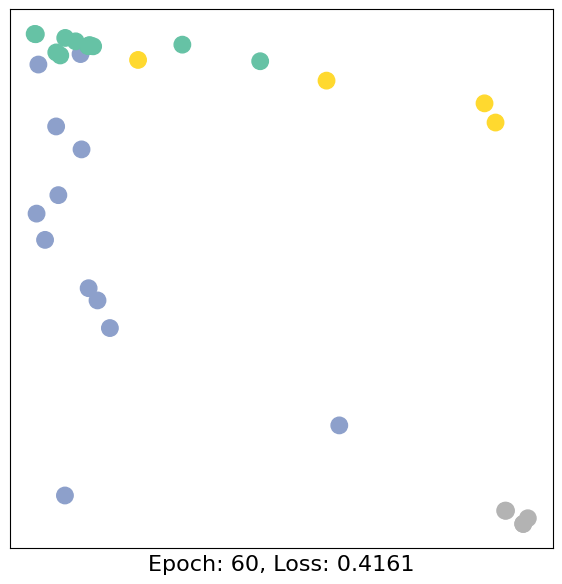

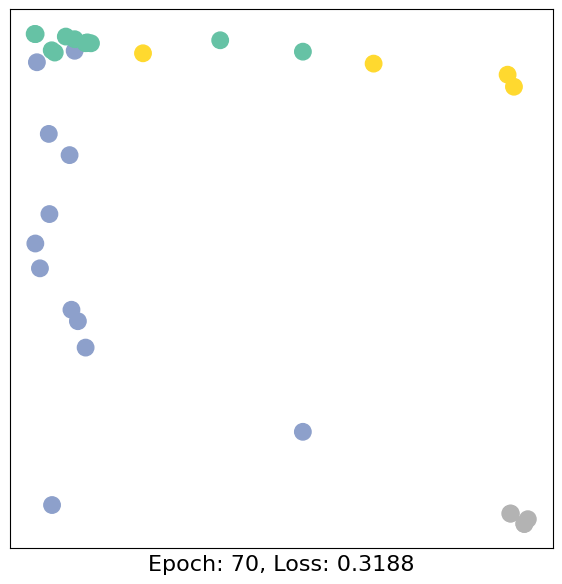

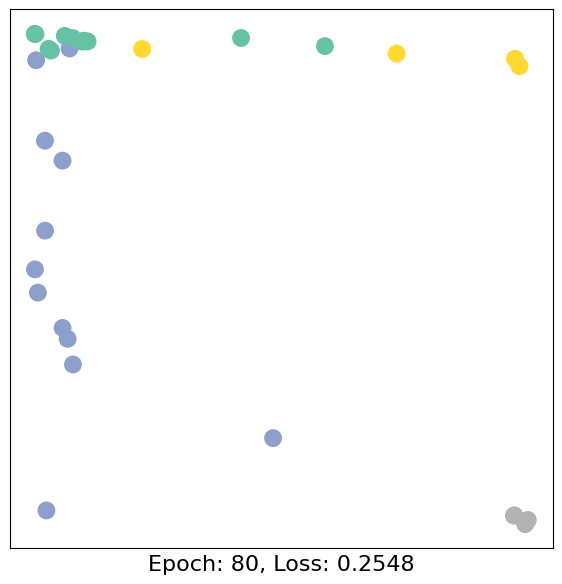

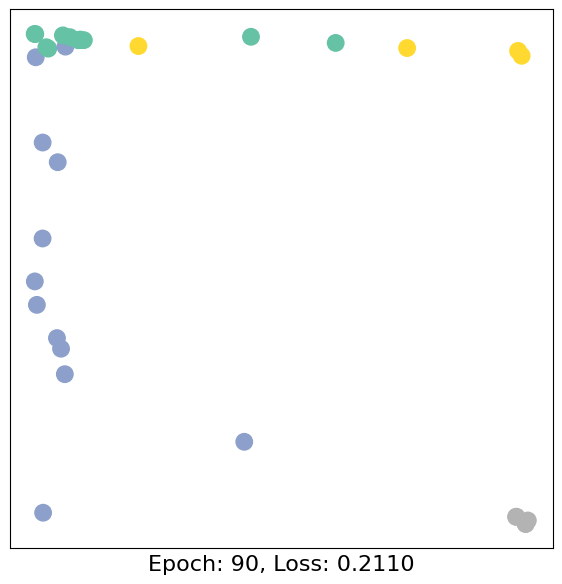

In [ ]:
import time
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
  optimizer.zero_grad()
  out,h = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) # semi-supervised
  loss.backward()
  optimizer.step()
  return loss, h

for epoch in range(100):
  loss, h = train(data)
  if epoch % 10 == 0:
    visualize_embedding(h, color = data.y,epoch=epoch, loss=loss)
    time.sleep(0.3)